In [1]:
import os
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import nltk.stem as stm
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [302]:
Reviews_df=pd.read_excel('Reviews7.xls')

In [303]:
Reviews_df.sample(5)

,Name,Id,Overall Rating,Percentage Would Recommend,Overall Difficulty,Review Qverall Quality,Review Difficulty,Review Text,Review Tags
7421,VladimirGurewich,2210052,4.7,89,2.8,3.0,3,He's a cool dude and all.. really attractive t...,PARTICIPATION MATTERS\r\r\nGIVES GOOD FEEDBACK...
14487,JoshuaFarrington,1797124,4.9,100,2.1,5.0,2,Best Teacher Ever. Josh you motivated me so mu...,INSPIRATIONAL\r\nHILARIOUS\r\nRESPECTED
16325,RobbyaGreen-Weir,1613683,3.1,81,3.6,5.0,2,She is an awesome teacher with real world expe...,AMAZING LECTURES\r\nCARING\r\nGIVES GOOD FEEDBACK
15202,ToddPrickett,1605942,4.9,83,2.2,4.5,3,He really knows his stuff. He's very kind and ...,NaN
2999,Thomas A.Underwood,1096366,4.7,60,3.6,5.0,3,TAKE THIS CLASS! Best professor I've ever had....,INSPIRATIONAL\r\r\r\nAMAZING LECTURES\r\r\r\nR...


In [304]:
Reviews_df.shape

(20742, 9)

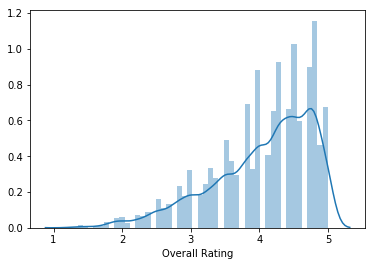

In [305]:
sns.distplot(Reviews_df['Overall Rating'])

In [308]:
number_entries=Reviews_df.shape[0]
running_sum=0
for i in range(0,number_entries):
    running_sum += (Reviews_df.loc[i]['Overall Rating']-4.0)**2
print(running_sum/number_entries)

0.538209430142


In [309]:
def nan_to_string(text):
    if type(text) != str:
        return ' '
    else:
        return text
Reviews_df['Clean Review Text'] = Reviews_df['Review Text'].apply(nan_to_string)
Reviews_df['Clean Review Tags'] = Reviews_df['Review Tags'].apply(nan_to_string)

In [310]:
Reviews_df['Clean Review Tags'] = Reviews_df['Clean Review Tags'].apply(lambda x: (" ".join(x.split())).lower() )

In [311]:
def text_plus_tags(row):
    return row['Clean Review Text'] + row['Clean Review Tags']
Reviews_df['Full Review'] = Reviews_df.apply(text_plus_tags, axis=1)

In [312]:
#Using NLTK to find only the stem of the word.
stemmer = stm.PorterStemmer()
Reviews_df['Full Review Stem'] = Reviews_df['Full Review'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split(" ")]))

In [207]:
Reviews_df.sample(5)

,Name,Id,Overall Rating,Percentage Would Recommend,Overall Difficulty,Review Qverall Quality,Review Difficulty,Review Text,Review Tags,Clean Review Text,Clean Review Tags,Full Review,Full Review Stem
1882,EmilyHavey,1899671,3.9,63,2.7,5.0,2,My favorite teacher this semester. Her class i...,RESPECTED\r\r\nPARTICIPATION MATTERS\r\r\nSKIP...,My favorite teacher this semester. Her class i...,respected participation matters skip class? yo...,My favorite teacher this semester. Her class i...,My favorit teacher thi semester. her class is ...
7341,AgneReizgeviciute,1913628,3.2,77,3.4,5.0,3,Agne is a great instructor. She stays updated ...,CARING\r\nRESPECTED\r\nGROUP PROJECTS,Agne is a great instructor. She stays updated ...,caring respected group projects,Agne is a great instructor. She stays updated ...,agn is a great instructor. she stay updat with...
8482,SyedRizvi,2316343,5.0,100,3.6,5.0,3,"Excellent Professor, taught us ver well and pr...",HILARIOUS\r\nINSPIRATIONAL,"Excellent Professor, taught us ver well and pr...",hilarious inspirational,"Excellent Professor, taught us ver well and pr...","excel professor, taught us ver well and provid..."
8112,DavidTiffany,1224311,3.8,73,3.2,5.0,3,One of my favorite professors. His lectures ma...,NaN,One of my favorite professors. His lectures ma...,,One of my favorite professors. His lectures ma...,one of my favorit professors. hi lectur may be...
3985,DavidManuel,1029974,4.3,88,3.3,5.0,2,Math 166 is one of the best things you can do!...,ACCESSIBLE OUTSIDE CLASS\r\r\nCLEAR GRADING CR...,Math 166 is one of the best things you can do!...,accessible outside class clear grading criteri...,Math 166 is one of the best things you can do!...,math 166 is one of the best thing you can do! ...


In [147]:
from sklearn.feature_extraction import text 
new_stop_words = text.ENGLISH_STOP_WORDS.difference({'she', 'he'})
new_stop_words;

In [313]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=new_stop_words,min_df=.03, max_df=.97, max_features=25000)#words and pairs of words
X = vectorizer.fit_transform(Reviews_df['Full Review Stem'])
X_vec=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

In [314]:
X_vec.shape

(20742, 204)

In [315]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()#smooth_idf=False)
tfidf = transformer.fit_transform(X.toarray())
X_vec_transform=pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

In [316]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Features = [features[i] for i in indices[:top_n]]
#scale = StandardScaler()
#X_all = scale.fit_transform(X_vec)#[Features])
X_all=X_vec_transform#[Features]
y_all = Reviews_df['Overall Rating']#['Would_Recommend']#

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test)

In [22]:
from sklearn.metrics import  mean_squared_log_error,  mean_squared_error

In [318]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.000001, max_iter=10000)
lasso.fit(X_train, y_train)
predictions= lasso.predict(X_test)
print(mean_squared_error(y_train, lasso.predict(X_train) ))
print(mean_squared_error(y_test,predictions) )

0.42485712615
0.433126382015


In [320]:
from xgboost import XGBClassifier, XGBRegressor
gbm = xgb.XGBRegressor(n_estimators=150)
gbm.fit(X_train, y_train)
predictions = gbm.predict(X_test)
print(mean_squared_error(y_train, gbm.predict(X_train)))
print(mean_squared_error(y_test, predictions))

0.392428334827
0.433323114166


In [321]:
from sklearn.linear_model import BayesianRidge
br = BayesianRidge() #ARDRegression()
br.fit(X_train, y_train)
predictions5= br.predict(X_test)
print(mean_squared_log_error(y_train, br.predict(X_train)))
print(mean_squared_log_error(y_test, predictions5))

0.0207088340814
0.0205921318915


In [322]:
pd.Series(gbm.booster().get_score(importance_type='weight')).sort_values(ascending=False) #'gain'

amaz               24
hard               23
good feedback      22
easi               20
grader             20
she                18
heavi              18
hilari             18
great              17
best               17
class              16
bad                15
ask                15
don                15
just               15
doesn              14
read               14
care               14
respect            13
veri               13
professor          13
teach              13
question           12
problem            12
ha                 12
particip           12
homework           11
make               11
assignments        11
love               11
                   ..
actual              2
everyth             2
particip matter     2
final               2
access outsid       2
he realli           2
best professor      1
took                1
helpful             1
know                1
work                1
won                 1
outsid              1
book                1
highli    

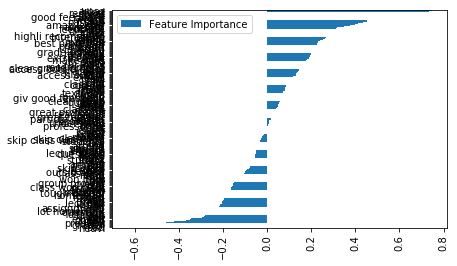

,Feature Importance
heavi,-0.633553
bad,-0.574425
grader,-0.503672
hard,-0.459757
problem,-0.457656
ask,-0.421977
offic,-0.369681
doesn,-0.349473
expect,-0.346708
just,-0.293106


In [323]:
FI_br = pd.DataFrame({"Feature Importance":br.coef_}, index=X_all.columns)
FI_br.sort_values("Feature Importance",ascending=False)
FI_br[FI_br["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh")#,figsize=(15,25))
plt.xticks(rotation=90)
plt.show()
FI_br[FI_br["Feature Importance"]!=0].sort_values("Feature Importance")

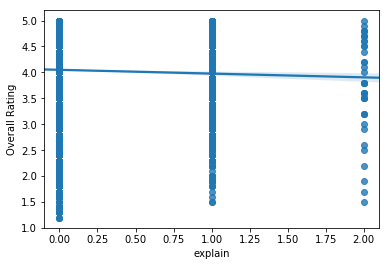

In [324]:
sns.regplot(x=X_vec['explain'], y=Reviews_df['Overall Rating'])

In [126]:
for j in Reviews_df.index:
    temp=re.finditer(r'explain',Reviews_df.loc[j]['Full Review Stem'])
    if temp != []:
        for match in temp:
            print(Reviews_df.loc[j]['Full Review'][match.start()-20:match.start()+8+20])

 does a great job at explaining everything. He r
rticipate in class and be prepared to explain wh
nts. She is very good at explaining the lesson. 
er I've ever had she explains thing clearly and 
pful, didn't really explain anything. Wasn't ver
over is not on the tests. he explains very well 
ny and is very efficient at explaining the mater
ver had. Very good at explaining things. Makes s
 he does and is good at explaining things. He ha
id great! He's great at explaining things in a w
t she did a wonderful job at explaining without 
r had! She is good at explaining the material an
's not easy, but she explains it very clearly an
s and it was easy. She explains stuff so anyone 
e slides several times and explain his study que
e will gladly come and explain it to you until y
f each chapter. Does not review/explain homework
ish she would slow down and explain things more 
 Ellen is very helpful and tries her best to exp
 is not paid for that) to explain and answer all
s wasn't easy, but h

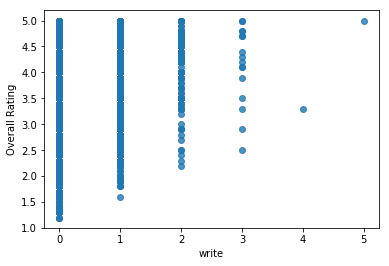

In [361]:
sns.regplot(x=X_vec['write'], y=Reviews_df['Overall Rating'], fit_reg=False)#, x_estimator=np.mean)#'confusing'

In [133]:
for j in Reviews_df.index:
    temp=re.finditer(r'write',Reviews_df.loc[j]['Full Review Stem'])
    if temp != []:
        for match in temp:
            print(Reviews_df.loc[j]['Full Review'][match.start()-20:match.start()+8+20])

ing. No tests, just easy papers on what you want
f nearly every class. He writes questions from t

ailable in her office to help me with writing my
 - not computer/lab. Writes material on board fo
 to understand due to accent. Writes extremely f
now how to read and write, you will be fine. She

, every week. I hate writing papers, I wish some
f class you will be asked to write a 500, and 2 
 on in your studies and write down info not in t
efully. Sometimes she writes the problems in rev
0 mc questions. Attend a colloquium, write a sho
ld definitely suggest printing out his slides an
o a lot of in class writing and turn in a short 
g and turn in a short writing at the end of ever
n topics youll probably enjoy writing about. Gra
alism because of him. He makes the writing promp

rite. There will be writing assignments in class
eadings, class discussion, write essay, peer rev
. Papers are on interesting topics & I enjoyed w
kly. I learned a lot about college writing and f
ence. There are 4

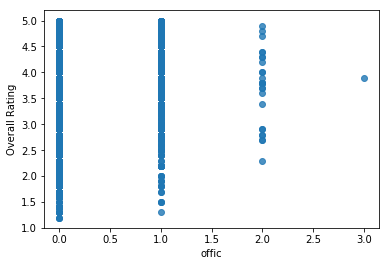

In [326]:
sns.regplot(x=X_vec['offic'], y=Reviews_df['Overall Rating'], fit_reg=False)#people really like office hours

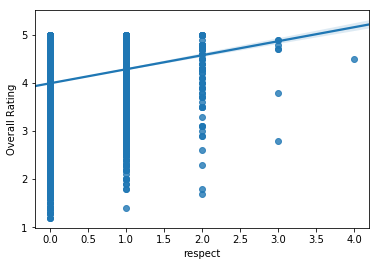

In [362]:
sns.regplot(x=X_vec['respect'], y=Reviews_df['Overall Rating'])#being respectful is important

In [168]:
for j in Reviews_df.index:
    temp=re.finditer(r'respect',Reviews_df.loc[j]['Full Review Stem'])
    if temp != []:
        for match in temp:
            print(Reviews_df.loc[j]['Full Review'][match.start()-20:match.start()+8+20])

ake her againGIVES GOOD FEEDBACK
RESPECTED
P
 He's much easier in-person than onlineRESPECTED
gret it unless your difficult. LolRESPECTED
PA
e econ majors, & he's definitely inspired me.RES
etter if taken in person though.RESPECTED
ion but is graded easily. Take him for Econ.!HIL
 LECTURES
SKIP CLASS? YOU WON'T PASS.
RESPEC
hings from english to beliefs but is always resp
OUS
GIVES GOOD FEEDBACK
RESPECTED
A
SKIP CLASS? YOU WON'T PASS.
RESPECTED
All around great teacher. :DRESPECTED
PARTICIP
her. Also laughs at his own jokes :)RESPECTED

 college.INSPIRATIONAL
HILARIOUS
RESPECTED
they were both good.RESPECTED
CARING
INSPIRA
and lexture. I got an AEXTRA CREDIT
RESPECTED
re. really loves his students.RESPECTED
HILARI
 at all lol.GIVES GOOD FEEDBACK
RESPECTED
CA
 you.AMAZING LECTURES
RESPECTED
GIVES GOOD F
Popular. Highly recommend.RESPECTED
CLEAR GRAD
recommend.CLEAR GRADING CRITERIA
RESPECTED
H
CLEAR GRADING CRITERIA
HILARIOUS
RESPECTED
ing wrong" is ridiculous and totally false.RESPE

e

nyone I've had  and is super funny!!!!!RESPECTED


INS


INSPIRA

SKIP CLASS


LOTS OF HOMEW
 class again! Great teacher! Great class!RESPECT


HILARIOUS




PART


A


GIVES GOOD FEEDB
He is very nice and respectful to people of diff
s to the letter. He needs respect above all, and
tructions is a way of giving him the respect he 
he needs. Also feel free to show him respect in 



GIVES GOOD FEEDB


RESPEC



RESPECTE







RESPECTED

RESP


RESPECTED

AMA


RESPECTED



RESPECTED
tly. Has an amazing ass too, haha. Take him!CARI


HIL
s lets people talk as long as they are respectfu
ad the textbook. 10/10 would recommend.RESPECTED
c, teaches it well, encourages respectful and me

GI


ACCESSIBLE

GROUP PROJE

SKIP


RESPECTED


RESPECTED
tions such as labs, tutorials etc so you wont fa

RESPECTED





ortunity to take one of her classes jump at it!!


rmation about the world around me. 8/10RESPECTED
 was fun, just not my favorite class of his.RESP


S
 big hints in exchange for a few

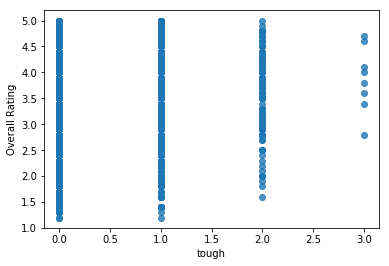

In [363]:
sns.regplot(x=X_vec['tough'], y=Reviews_df['Overall Rating'], fit_reg=False)#being tough, on its own, is not bad

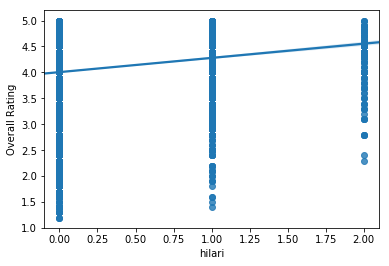

In [329]:
sns.regplot(x=X_vec['hilari'], y=Reviews_df['Overall Rating'])#'hilarious' jokes are good

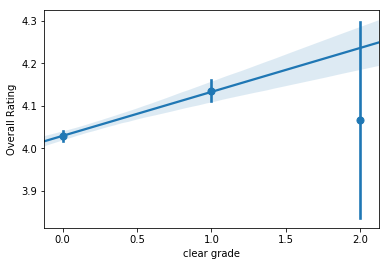

In [365]:
sns.regplot(x=X_vec['clear grade'], y=Reviews_df['Overall Rating'], x_estimator=np.mean)#having a clear grading scheme is important

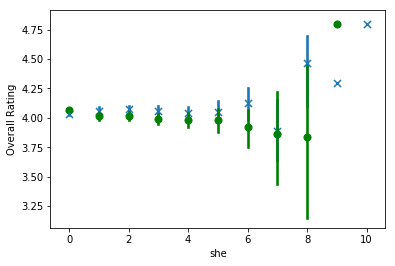

In [339]:
sns.regplot(x=X_vec['he'], y=Reviews_df['Overall Rating'],marker='x', fit_reg=False, x_estimator=np.mean)
sns.regplot(x=X_vec['she'], y=Reviews_df['Overall Rating'], color='green', fit_reg=False, x_estimator=np.mean)

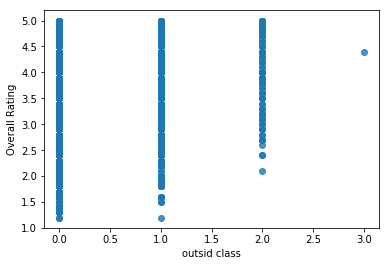

In [354]:
sns.regplot(x=X_vec['outsid class'], y=Reviews_df['Overall Rating'], fit_reg=False)#, x_estimator=np.mean)

In [173]:
for j in Reviews_df.index:
    temp=re.finditer(r'outsid class',Reviews_df.loc[j]['Full Review Stem'])
    if temp != []:
        for match in temp:
            print(Reviews_df.loc[j]['Full Review'][match.start()-20:match.start()+8+20])

.BEWARE OF POP QUIZZES
ACCESSIBLE OUTSIDE CLAS
ING CRITERIA
ACCESSIBLE OUTSIDE CLASS
un. She is a great professor and person!ACCESSIB
ING
GIVES GOOD FEEDBACK
ACCESSIBLE OUTSIDE C
AD
GRADED BY FEW THINGS
ACCESSIBLE OUTSIDE C
AMAZING LECTURES
RESPECTED
ACCESSIBLE OUTSID
s directly connected to my major.ACCESSIBLE OUTS
me to help me when I needed it.ACCESSIBLE OUTSID
IPATION MATTERS
GIVES GOOD FEEDBACK
ACCESSIB
ARTICIPATION MATTERS
ACCESSIBLE OUTSIDE CLASS
hes everything  really well.CARING
ACCESSIBLE 
ttention. No Final.LOTS OF HOMEWORK
ACCESSIBLE
courses.CLEAR GRADING CRITERIA
ACCESSIBLE OUTS
ICIPATION MATTERS
ACCESSIBLE OUTSIDE CLASS
ATION MATTERS
INSPIRATIONAL
ACCESSIBLE OUTSI
OOD FEEDBACK
CLEAR GRADING CRITERIA
ACCESSIB

GIVES GOOD FEEDBACK
ACCESSIBLE OUTSIDE CLASS
TA are always willing to answer questions!ACCESS
re Machine Learning. Recommended!CARING
ACCESS
d.RESPECTED
ACCESSIBLE OUTSIDE CLASS
CARING

INSPIRATIONAL
ACCESSIBLE OUTSIDE CLASS
 graduate !AMAZING LECTURES
ACCESSIBLE OUT



ACCESSIBLE OUTSIDE CLASS
 the instructions for extra points.ACCESSIBLE OU




ACCESSIBLE OUTSIDE CL



ACCESSIBLE OUTSI
 just expect a good gradeACCESSIBLE OUTSIDE CLAS

ACCESSIBLE OUTSIDE CLASS
mulative and attendence is worth 50 ptsACCESSIBL

ACCESSIBLE OUTSIDE CLAS
 Would highly recommend him!ACCESSIBLE OUTSIDE C

ACCESSIBLE OUTSIDE 

PARTICIPATION MATTERS

ACCESSIBLE O
o take the opportunity to get extra help outside

ACCESSIBLE
ized. Quizzes can be tricky.ACCESSIBLE OUTSIDE C


ACCESSIBLE OUTS


ACCESSI

ACCESSIBLE OUTSIDE CLASS

ACCESSIBLE OUTSIDE CLA


ACCESSIBLE OUTSIDE CLASS

ACCESSIBLE OUTSIDE CLASS
of. frequently brought in treats, too!ACCESSIBLE

ACCESSIBLE OUT
h!  She emails me back a lot too.ACCESSIBLE OUTS



ACCESSIBLE OUTSIDE CLASS


A
tle extra effort an A is attainable.ACCESSIBLE O


GI


ACCESSIBLE OUTSIDE
 posts about 10 discuss.ACCESSIBLE OUTSIDE CLASS

ACCESSIBLE OUTSIDE C

ACCESSIBLE OUT


ACCESSIBLE O


ACCESSIBLE OUTSIDE CLASS


ACCESSIBLE OUTSIDE CLASS


AC

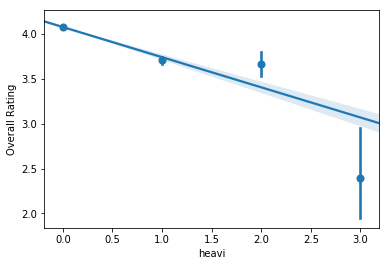

In [351]:
sns.regplot(x=X_vec['heavi'], y=Reviews_df['Overall Rating'], x_estimator=np.mean)# diversity is important, lecture heavy is bad
#sns.regplot(x=X_vec['lectur heavi'], y=Reviews_df['Overall Rating'], color='green')

In [218]:
for j in Reviews_df.index:
    temp=re.finditer(r'heavi',Reviews_df.loc[j]['Full Review Stem'])
    if temp != []:
        for match in temp:
            print(Reviews_df.loc[j]['Full Review'][match.start()-20:match.start()+8+20])

 of pop quizzes get ready to read lecture heavy
open note. Gives great career advice.lecture hea
t ready to read beware of pop quizzes lecture he
nd participate you'll be fine.participation matt
erial in exam guides.beware of pop quizzes tough
in summarizing the information.graded by few thi
an A by completing the homework.lecture heavy lo
work participation matters lecture heavy
few things lots of homework test heavy
ll you willextra credit lecture heavy
ogs you will love her!lecture heavy hilarious sk
ss is passable.lecture heavy skip class? you won
ip class? you won't pass. lecture heavy amazing 
s VERY slow. Easy A if you go to class!lecture h
nd. He does give extra credit though.lecture hea
 enough to get an A on the weekly quizzes.lectur
o jot down all the infoskip class? you won't pas
couple of quizzes and midterms.lecture heavy
requirement for SWMS majors.lots of homework lec
reviews for the tests.respected test heavy
rading criteria lots of homework lecture heavy
clear grading

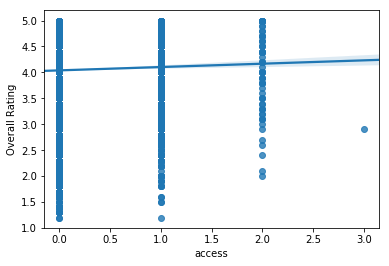

In [344]:
sns.regplot(x=X_vec['access'], y=Reviews_df['Overall Rating'])#, x_estimator=np.mean)#"accessible"

In [374]:
vectorizer.vocabulary_['handwrit']# handwriting is not important enough to mention, in < 3% of reviews

KeyError: 'handwrit'

In [349]:
len(Reviews_df['Id'].value_counts().index)*4.34

11995.76